# Analysis of a Simpson's paradox example dataset

[Simpson's Paradox](https://plato.stanford.edu/entries/paradox-simpson/) is a statistical phenomenon where an association between two variables in a population emerges, disappears or reverses when the population is divided into subpopulations. It can have serious consequences because people easily confuse association with causal relationship and infer wrong conclusion. Classical example of Simpson's paradox is [University of California as Berkeley 1973 admission dataset](https://discovery.cs.illinois.edu/dataset/berkeley/). We shall briefly analyze this dataset here in order to resolve the paradox.

## Was there a sex bias in Berkeley graduate admissions?

In the Fall of 1973, the University of California at Berkeley released data about their graduate admissions. At the first glance, the data showed a significant difference in the acceptance rate for male and female applicants. They had admitted 44.3% of men and only 34.6% of women.

Is this difference really significant? Is there a bias in application procedure? Is there something that applicants should complain about? Did we have sex-based discrimination at Berkley? We shall try to answer these questions in this article using some data analysis and visualization.

Firstly, let's see the data.

In [1]:
import pandas as pd
df=pd.read_csv("https://waf.cs.illinois.edu/discovery/berkeley.csv")
df

,Year,Major,Gender,Admission
0,1973,C,F,Rejected
1,1973,B,M,Accepted
2,1973,Other,F,Accepted
3,1973,Other,M,Accepted
4,1973,Other,M,Rejected
...,...,...,...,...
12758,1973,Other,M,Accepted
12759,1973,D,M,Accepted
12760,1973,Other,F,Rejected
12761,1973,Other,M,Rejected


Here we have application outcomes for 12,763 applicants. They were either accepted or rejected. The __Major__ column indicates which department the candidates applied for. Actually, we see just the labels, but this should be enough for the purpose of statistical analysis. We see, also, applicants' gender as well and the year of admission. The year data is always the same: 1973. We could ignore it.

In [2]:
df.drop('Year',axis=1, inplace=True)

Let's see how many male and female applicants were accepted and rejected. For the purpose we will use pandas function for cross-tabulation: `crosstab()`.

In [3]:
ct=pd.crosstab(df.Gender, df.Admission)

In [4]:
# cross-tabulation
ct

Admission,Accepted,Rejected
Gender,,
F,1494,2827
M,3738,4704


We can see that much fewer women were accepted but also that much fewer women applied. It is hard to say whether the admission difference between male and female applicants is significant. We can test this doubt in two ways. One is to apply statistical test. That is how most of scientists would do it. The other approach is how we could do it without statistical tests - just with simulation of possible outcomes. We will start with the latter approach.

### Simulation of an unbiased admission

We shall assume that application procedure is unbiased and simulate possible admission results. For every applicant in the array, we should simulate admission in the same way regardless the candidate's gender. In order to create such a simulation, we need an array of random numbers between 0 and 1 as long as the array of candidates is. If a number in the array is greater than the threshold we would say the candidate is accepted. Otherwise, we would say he/she is rejected. For the threshold we will use the ratio the of number of candidates who were accepted and the number of applicants. 

In [5]:
import numpy as np

In [6]:
# total number of candidates and number of those who were accepted
n=len(df)
a=len(df[df.Admission=='Accepted'])

The array **sim_adm** contains values 0 and 1 for rejected and accepted candidates.

In [7]:
sim_adm=np.array(np.random.rand(n)+a/n,dtype="int")

Let's see what the crosstabulation would look like in this particular simulated case.

In [8]:
pd.crosstab(df.Gender,sim_adm)

col_0,0,1
Gender,,
F,2532,1789
M,4940,3502


Again, we have much fewer female applicants as well as much fewer admitted women. In this simulated case 1806 women were accepted while in the observed dataset there are 1494 of them. Is this difference significant? We can't say that yet. One simulated outcome is not enough to infer anything. We will repeat the simulation 1000 times, record the number of accepted female applicants for all of them and display this data graphically.

In [9]:
sim_fa=np.zeros(1000)

In [10]:
for i in range(1000):
    sim_adm=np.array(np.random.rand(n)+a/n,dtype="int")
    fem_acc=pd.crosstab(df.Gender,sim_adm).iloc[0,1]
    sim_fa[i]=fem_acc

In [11]:
import matplotlib.pyplot as plt

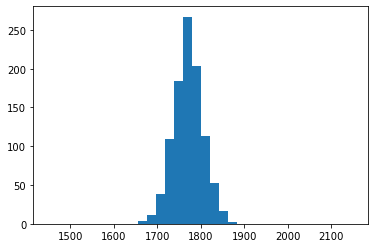

In [12]:
plt.hist(sim_fa,bins=np.linspace(1450,2150,35));

What we see here is the distribution of the number of accepted female candidates in 1000 simulated unbiased admissions. This is what we should expect for the number of accepted women if the number of female applicants stay the same. Distribution of simulated outcomes is bell-shaped where the great majority of outcomes lie between 1700 and 1850. The real-data outcome (1494) is far smaller than the expected values. In other words, probability that Berkeley accepts only 1494 women is very low, much lower than 1 in 1000.

It is clear that the acceptance rate for male and female candidates for University of California at Berkeley was not the same. For women it was significantly more difficult to enroll in 1973. Is this evidence hard enough to accuse Berkeley of discrimination? No! There are at least three reasons why we shouldn't run into conclusion that the bias was intentional Firstly, events with probability less than 0.1% happen all the time. It could be just a coincidence. Secondly, statistically significant differences without the cause can't be taken as serious evidence. We need some theory behind this data. Thirdly, there might be some confounding variable, which has nothing to do with Berkeley, influencing acceptance rate.

### Statistical test $\chi^2$

There is a commonly used statistical test for contingency tables called $\chi^2$ or chi-square or just chi2 (if you want to google it). Pearson's $\chi^2$ test determines whether there is a statistically significant difference between the expected frequencies and the observed frequencies in one or more categories of a contingency table. A function for this test can be found in scipy.stats library.   

In [13]:
from scipy.stats import chi2_contingency 

In [14]:
stat, p, dof, arr=chi2_contingency(ct)

Here we have three outputs: statistic $\chi^2$ (__stat__), _p_-value (__p__) and the number of the degrees of freedom (__dof__). Right now, we are interested in _p_-value only. It stands for estimated probability that observed results can be this far from results expected under the assumption that acceptance rate does not depend on the gender. Using simulation, we have already estimated that this probability must be much lower than 0.001. Let's see what statistical test says.

In [15]:
p

6.385628329926473e-26

If this exponential form of the number is not convincing enough, we can print it with all the leading zeroes.

In [16]:
print("p=%0.26f" % p)

p=0.00000000000000000000000006


Definitely, the probability of the observed outcome is extremely low. If we had repeated admission at Berkeley every day since the Big Bang, it still would be extremely unlikely that we ever obtain such an outcome. Can we now accuse Berkeley for discrimination? Such results can't be a coincidence. The answer is same as before. No, we need at least "a motive for murder" like in criminalistic series. Instead, we can look for the confounding variables.

### Looking for the confounding variable

The only recorded variable that could be confounding is __Major__. Results that look biased for the whole university might be different if we stratify the sample and look at subgroups, i.e. departments.

In [17]:
df['Major'].value_counts()

Other    7924
A        1246
C         918
D         792
F         714
B         585
E         584
Name: Major, dtype: int64

Unfortunately, we have labels for the six biggest departments only (A-E). All the others are put in a vast category "Other". If the major is really the confounding variable, mixing outcomes into "Other" category would just blurry the results. We should exclude this category. Anyway, Simpson's paradox appears to be even more obvious if we take the candidates who applied for the labeled departments only. Therefore, we will exclude those who applied for "Other".

In [18]:
df2=df[df.Major!='Other']

In [19]:
df2

,Major,Gender,Admission
0,C,F,Rejected
1,B,M,Accepted
6,F,F,Accepted
9,A,M,Accepted
11,B,M,Accepted
...,...,...,...
12747,A,M,Accepted
12748,F,M,Rejected
12752,A,M,Accepted
12754,A,M,Accepted


> Suggestion: Repeat simulation and statistical test for this truncated data frame. Do we have extremely low _p_-value again?

In [20]:
dfA=df[df.Major=='A']

In [21]:
ctA=pd.crosstab(dfA.Gender, dfA.Admission)

In [22]:
ctA

Admission,Accepted,Rejected
Gender,,
F,89,19
M,825,313


In [23]:
stat, p, dof, arr=chi2_contingency(ctA)

In [24]:
p

0.034619660876707294

The difference is still statistically significant, barely, but _p_<0.05. Although the significance is not so convincing, we see the same bias. But wait! There is a difference in acceptance rate but female candidates for the major A have GREATER acceptance rate than the male! For women acceptance rate is 87% while for the men it is 72%. It seems that we have found a hole in that biased admission logic. Major could be the confounding variable.

You can do the same statistical analysis for all majors, but it could be better to visualize these contingency tables. There are a lot of ways to visualize a Simpson's paradox example dataset, which don't contribute much to the clarity. We want something better, a visualization that reveals what really matters.

### Visualization of the Berkeley dataset

This visualization has several steps since we have to create it from scratch. Already available charts won't be good enough. Be patient. We will do it step by step.

Firstly, we would like to compare the acceptance rate for both sexes and all available majors regardless the number of applicants. That is why on the y-axis we should put acceptance rate given as percentage. 

In [25]:
# maximal height (percentage)
h=100

In [26]:
# number of F and M applicants per major
noa=pd.crosstab(df2.Gender,df2.Major)

In [27]:
# total number of applicants per major
toa=noa.sum()

In [28]:
# number of majors
nom=len(df2.Major.unique())

In [29]:
# list of outcomes
outcomes=df2.Admission.unique()

In [30]:
# number of accepted candidates per major
nos=pd.crosstab(df2['Gender'][df2.Admission==outcomes[1]],df2['Major'][df2.Admission==outcomes[1]])

We will display the percentage of accepted candidates as the light part of bar. The rest up to 100% is dark. They are rejected. 

In [31]:
# acceptance rate data frame
ar=nos/noa

In [32]:
# bar height (percentage of acceptance)
ha=ar.transpose().to_numpy().flatten()*100

Number of candidates will be displayed through the bars' width. The wider bar, the more candidates applied. Of course, the width should be scaled. Width 1 will be assigned to the major with the most applicants.

In [33]:
# relative weight (number of applicants)
w=noa/max(toa)

In [34]:
# set x-axis
x=np.linspace(1,nom,nom)

In [35]:
# distance between middles of adjacent bars
interspace=1.05

In [36]:
# shifted bars' positions for male and female 
shift=pd.DataFrame([x-(toa/max(toa)-w.iloc[0,:])/2/interspace,x-(toa/max(toa)-2*w.iloc[0,:]-w.iloc[1,:])/2/interspace])

In [37]:
# rearanged x-axis
x2=shift.transpose().to_numpy().flatten()

In [38]:
# bars' width
wl=w.transpose().to_numpy().flatten()

Finally, we plot six groups of bars for each major. Left bar is for female candidates, the right for male.

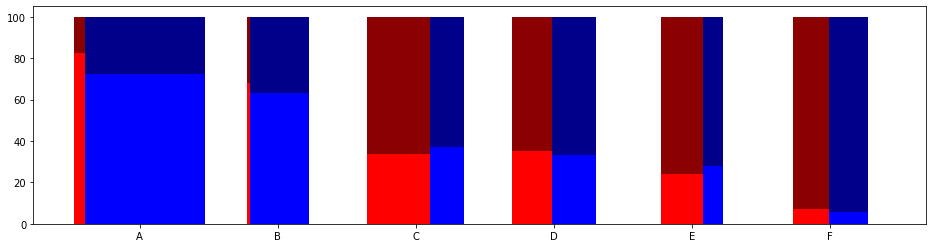

In [39]:
# barplot
plt.figure(figsize=(16, 4))
plt.bar(x2,height=h,width=wl/interspace,color=['darkred','darkblue'])
plt.bar(x2,height=ha,width=wl/interspace,color=['red','blue'])
plt.bar(x, 0, tick_label=noa.columns);

Take a look. What can we see here? For instance, the most of candidates applied for major A. Only a small fraction of applicants were women. Fraction of women in major B was even smaller. What is more important, we can see that differences in acceptance rates is much greater between majors than between sexes. If we look acceptance rate for men and women for particular majors, the difference is not so big.

Why do we notice such a difference in the acceptance rate for the whole university if it doesn't exist on the department level? It is simple. Women were reluctant to apply to majors with high acceptance rate (i.e. A and B) so there were greater number of men were accepted. They tended to apply more for the majors with low acceptance rate so the successful outcomes were not so numerous. Although we don't know what is behind the major labels, we can imagine that more women in 1973 applied for humanities than for engineering, while men tended to apply in higher numbers to engineering and science departments.

It looks like the major was the confounding variable, which had decisive influence on the acceptance rate. Typically, men and women prefer different majors so their choice of major actually creates this picture of biased admission.

### Observational study

Data obtained from the Berkeley admission office is not a result of an experiment. This data is just an observation of something that happened. All the performed analysis is observational study. If our intention was to test if University of California at Berkeley had discriminating women during the admission process, we should have designed an experiment for this. In the experiment, we should prepare almost identical treatment and control group. For instance, we should compare acceptance rate of 100 randomly selected male candidates with 100 randomly selected female candidates. It is difficult to make experiments with the admission process. We should do what we can with observations.  

### Brief conclusion

Simpson’s paradox can have serious consequences because people easily confuse association with causal relationship and infer wrong conclusion. We should be always cautious while interpreting observational data. Often, people don't recognize the confounders. In this example, it was easy to identify confounder variable because it was the only available in the dataset, but in general case it could be challenging. Insights gained by splitting data according to factors may help us to explain observed associations.

> ### Bonus: Function for the visualization made above
If you have similar dataset that needs to be visualized in the same manner, here is a function that combines all previous cells. Put your data frame as an argument. Just pay attention to the order of columns. Categorical variable that turned out to be the confounding variable is in the first column, binary variable that separates bars into left and right parts is in the second, while the outcome was in the third.

In [40]:
def lrp_bars(f):
    h=100
    noa=pd.crosstab(f.iloc[:,1],f.iloc[:,0])
    toa=noa.sum()
    nom=len(noa.columns)
    outcomes=f.iloc[:,2].unique()
    nos=pd.crosstab(f.iloc[:,1][f.iloc[:,2]==outcomes[1]],f.iloc[:,0][f.iloc[:,2]==outcomes[1]])
    ar=nos/noa
    ha=ar.transpose().to_numpy().flatten()*100
    w=noa/max(toa)
    x=np.linspace(1,nom,nom)
    interspace=1.05
    shift=pd.DataFrame([x-(toa/max(toa)-w.iloc[0,:])/2/interspace,x-(toa/max(toa)-2*w.iloc[0,:]-w.iloc[1,:])/2/interspace])
    x2=shift.transpose().to_numpy().flatten()
    wl=w.transpose().to_numpy().flatten()
    plt.bar(x2,height=h,width=wl/interspace,color=['darkred','darkblue'])
    plt.bar(x2,height=ha,width=wl/interspace,color=['red','blue'])
    plt.bar(x,0,tick_label=noa.columns)

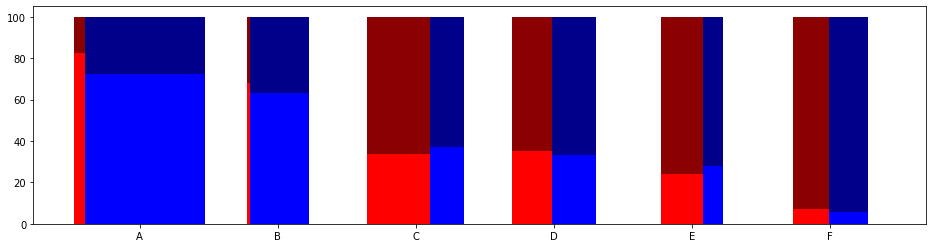

In [41]:
plt.figure(figsize=(16, 4))
lrp_bars(df2)